In [3]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import zipfile 
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
from tf.keras.layers import Layer
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
class InstanceNormalization(Layer):
    def __init__():
        pass

In [2]:
img =os.listdir("monet_tfrec");

In [35]:
# Obtener los paths de las imagenes
paths=[]
for im in img:
    paths.append(os.path.join("monet_tfrec",im)) 

## Read TFRecord

In [24]:
#Tamaño requerido de la imagen
IMAGE_SIZE = [256, 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels =3)
    image = (tf.cast(image, tf.float32)/127.5)-1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
def read_tfrecord(example):
    tfrecord_format ={
        "image_name":tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target":tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [25]:
def load_dataset(filenames,labeled = True, ordered = False):
    #Obtener los tfrec a partir de la lista de paths
    dataset = tf.data.TFRecordDataset(filenames)
    #aplicar la funcion read_tfrecord al dataset
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset


In [37]:
monet_tf = load_dataset(paths, labeled=True).batch(1)

In [38]:
example_monet = next(iter(monet_tf))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


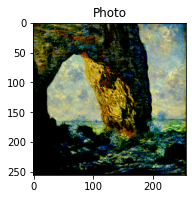

In [41]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_monet[0])

### Build generator

In [66]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm = True):
    ##Inicializa con distribucion normal los tensores (mean, desviacion)
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev=0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                     kernel_initializer=initializer, use_bias = True))
    if apply_instancenorm:
        result.add(tf.keras.layers.BatchNormalization(gamma_initializer=gamma_init))
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [67]:
def upsample(filters, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev  = 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization(gamma_initializer=gamma_init))
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result
                    
    

In [57]:
def Generator():
    inputs = tf.keras.layers.Input(shape = [256,256,3])
    
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout = True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides = 2, padding = 'same',
                                           kernel_initializer = initializer, activation='tanh')
    
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skip = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs = inputs, outputs = x)

## Build the discriminator

In [62]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)
    
    inp = tf.keras.layers.Input([256, 256, 3])
    
    x = inp 
    
    down1  = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides = 1, 
                                  kernel_initializer = initializer, use_bias = False)(zero_pad1)
    norm1 = tf.keras.layers.BatchNormalization(gamma_initializer= gamma_init)(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 4 , strides = 1, kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs = inp, output = last)
    

In [68]:
monet_generator = Generator()

photo_generator = Generator()

monet_discriminator = Discriminator()

photo_discriminator = Discriminator()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 2, 2, 512), (None, 128, 128, 64)]

### Build the cycleGan model

In [ ]:
class CycleGan(tf.keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle = 10):
        super(CycleGan, self).__init__()
        self.m_gen  = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    ##Se inicializan los optimizadores y loss    
    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn,
               disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)
            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            
            
            

## Write TFRecords

In [ ]:
def _bytes_features(value):
    if isinstance(value,type(tf.constant(0))):
        value = value.numpy()
        
    return tf.train.Feature(bytes_list = tf.train.BytesList(value= [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

def _int64_feature(value):
    
